In [31]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

## Claims data set

In [32]:
df = (
    pd.read_table('~/Downloads/P&Cdata.txt')
    .drop(columns=['ID'])
    .fillna(0)
)
df.head()

,NCLAIMS,AMOUNT,AVG,EXP,COVERAGE,FUEL,USE,FLEET,SEX,AGEPH,BM,AGEC,POWER,PC,TOWN,LONG,LAT
0,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,0,0.000000,0.000000,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,0,0.000000,0.000000,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,0,0.000000,0.000000,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


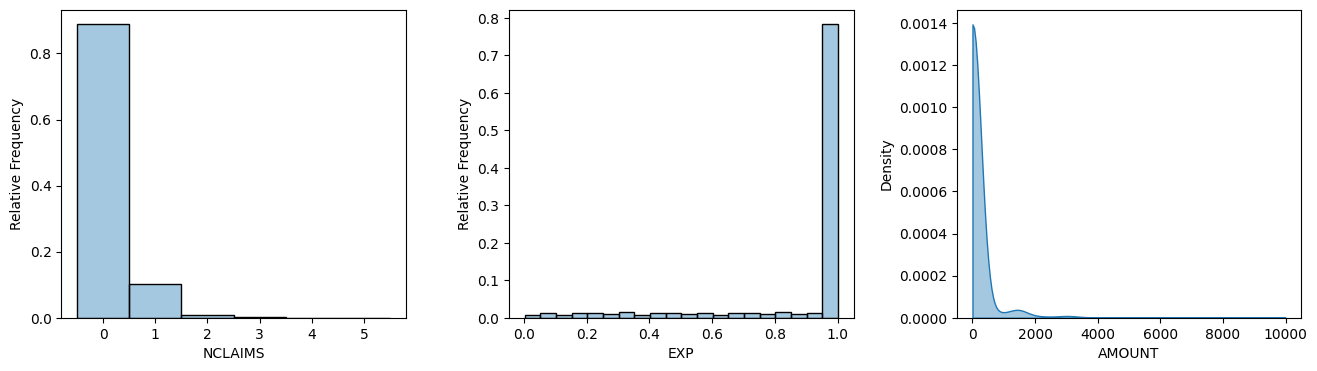

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(wspace=0.3)
sns.histplot(df['NCLAIMS'], discrete=True, stat='proportion', alpha=0.4, ax=ax[0])
sns.histplot(df['EXP'], stat='proportion', bins=20, alpha=0.4, ax=ax[1])
sns.kdeplot(df['AMOUNT'], alpha=0.4, clip=(0, 10_000), bw_adjust=0.5, fill=True, ax=ax[2])
ax[0].set_ylabel('Relative Frequency')
ax[1].set_ylabel('Relative Frequency')
plt.show()

### Categorical risk factors

* COVERAGE
* FUEL
* SEX
* USE
* FLEET

In [116]:
df['COVERAGE'].value_counts(dropna=False)/len(df)*100

COVERAGE
TPL    58.283047
PO     28.173570
FO     13.543383
Name: count, dtype: float64

In [117]:
df['FUEL'].value_counts(dropna=False)/len(df)*100

FUEL
gasoline    69.124737
diesel      30.875263
Name: count, dtype: float64

In [118]:
df['SEX'].value_counts(dropna=False)/len(df)*100

SEX
male      73.549755
female    26.450245
Name: count, dtype: float64

In [119]:
df['USE'].value_counts(dropna=False)/len(df)*100

USE
private    95.173098
work        4.826902
Name: count, dtype: float64

In [120]:
df['FLEET'].value_counts(dropna=False)/len(df)*100

FLEET
N    96.832097
Y     3.167903
Name: count, dtype: float64

### Continuous risk factors

* AGEPH
* POWER
* AGEC
* BM

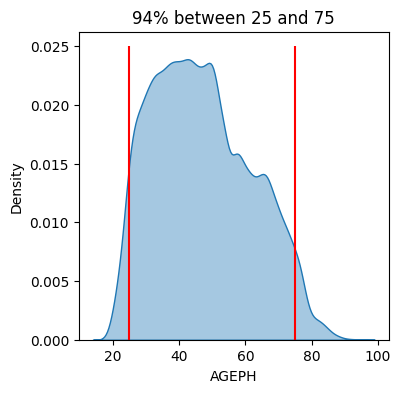

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.kdeplot(df['AGEPH'], alpha=0.4, fill=True, ax=ax)
ax.vlines(x=[25,75],ymin=[0,0],ymax=[0.025,0.025], color='red')
ax.set_title('94% between 25 and 75')
plt.show()

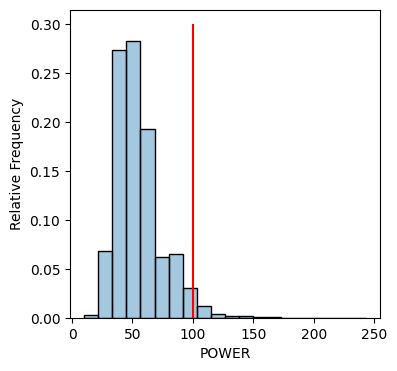

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.histplot(df['POWER'], stat='proportion', alpha=0.4, bins=20, ax=ax)
ax.vlines(x=100,ymin=0,ymax=0.3, color='red')
ax.set_ylabel('Relative Frequency')
plt.show()

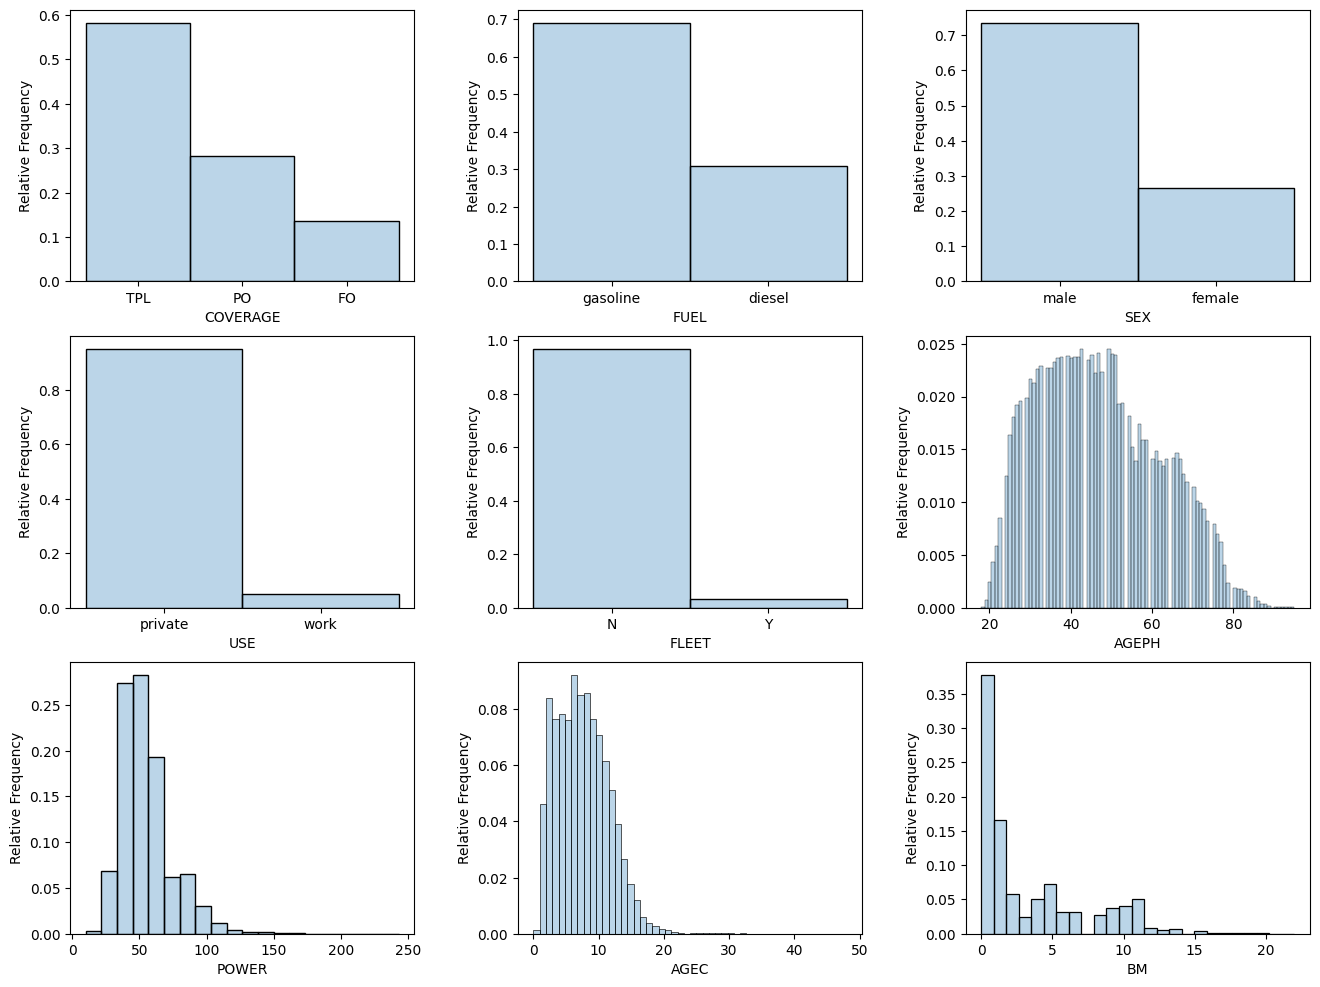

In [189]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
plt.subplots_adjust(wspace=0.3)
sns.histplot(df['COVERAGE'], discrete=True, stat='proportion', alpha=0.3, ax=ax[0,0])
sns.histplot(df['FUEL'], discrete=True, stat='proportion', alpha=0.3, ax=ax[0,1])
sns.histplot(df['SEX'], discrete=True, stat='proportion', alpha=0.3, ax=ax[0,2])
sns.histplot(df['USE'], discrete=True, stat='proportion', alpha=0.3, ax=ax[1,0])
sns.histplot(df['FLEET'], discrete=True, stat='proportion', alpha=0.3, ax=ax[1,1])
sns.histplot(df['AGEPH'], stat='proportion', alpha=0.3, ax=ax[1,2])
sns.histplot(df['POWER'], stat='proportion', alpha=0.3, bins=20, ax=ax[2,0])
sns.histplot(df['AGEC'], stat='proportion', alpha=0.3, bins=50, ax=ax[2,1])
sns.histplot(df['BM'], stat='proportion', alpha=0.3, bins=25, ax=ax[2,2])
for i in range(3):
    for j in range(3):
        ax[i,j].set_ylabel('Relative Frequency')
plt.show()

In [191]:
gdf = gpd.read_file('zip:///home/daltonkw/Downloads/postcode.zip')

<Axes: >

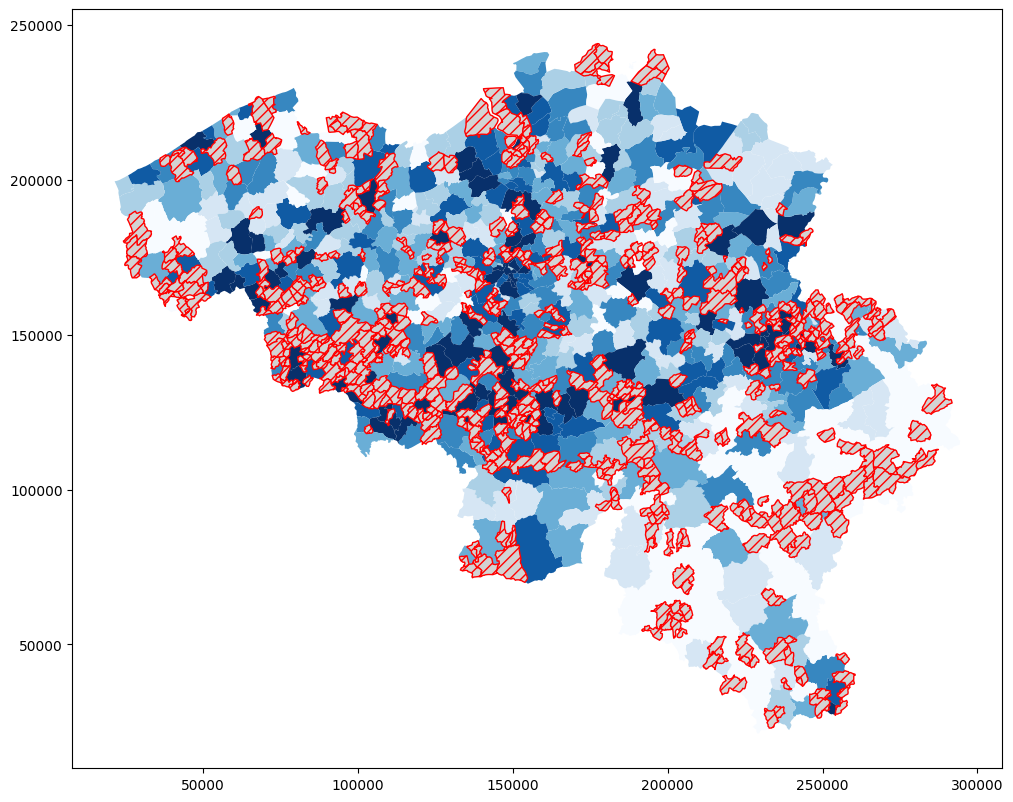

In [222]:
exp_gdf = pd.merge(
    left=gdf,
    right=pd.DataFrame(df.groupby('PC').agg('sum')['EXP']).reset_index().rename(columns={'PC':'POSTCODE'}),
    how='left',
    on='POSTCODE'
)

exp_gdf.plot(
    column='EXP',
    figsize=(12, 12),
    cmap='Blues',
    scheme='quantiles',
    k=7,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    })

## Flexible models using GAMs

$$
F_i=\frac{N_i}{e_i} \\
S_i=\frac{L_i}{N_i} \\
\pi_i=\mathbb{E}\left[F_i \right] \times \mathbb{E}\left[S_i \right], N_i > 0
$$

### Frequency

Goal is to explain number of claims, for a given exposure using a Poisson GAM.

$$
\begin{align*}
\log (\mathbb{E}(\text { NCLAIMS }))= & \log (\text{EXP} )+\beta_{0}+\beta_{1} \text { COVERAGE }_{PO}+\beta_{2} \text { COVERAGE }_{FO}+\beta_{3} \text { FUEL }_{\text {diesel }}+ \\
& \beta_{4} \text { SEX }_{\text {female }}+\beta_{5} \text { USE }_{\text {work }}+\beta_{6} \text { FLEET }_Y+f_{1}(\text { AGEPH })+f_{2}(\text { POWER })+  \tag{3}\\
& f_{3}(\text { AGEC })+f_{4}(\mathrm{BM})+f_{5}(\text { LONG }, \text { LAT }) .
\end{align*}
$$